# Compare two model outputs and observations

Reference: https://github.com/poplarShift/ice-edge/blob/master/iceedge_analysis.ipynb

# Set input directories

In [1]:
indir_model1='../../run_20210614_0000_EXP0_defineGUD_READ_PARUICE_grp_Xmin1Em4'
indir_model2='../../run_20210726_0000_EXP0_defineGUD_READ_PARUICE_grp_Xmin1Em4_20y'

# First, load libraries

In [2]:
import inspect
import numpy as np
import os
import os.path
import pandas as pd
from pathlib import Path
import scipy
import scipy.interpolate
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
# answer of Remi
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import netcdf_tools
import vstats

plt.close("all")

# Select year

In [3]:
years=range(1,11)
nbyears=len(years)
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT_model1=last_year

In [4]:
# years=range(1,21)
# nbyears=len(years)
# first_year=np.arange(0,365)
# last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
# array1d_iT1y_iT_model2=last_year

In [5]:
first_year366=np.arange(0,366) # first year for heatmaps

# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

it corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [6]:
gridfile='../grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m)

In [7]:
RC=netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m)

In [8]:
RF=netcdf_tools.read_netcdf(gridfile,'RF')

In [9]:
RF_above81=RF[RF>-82]

# Observations

Create directory validation if it doesn't exit.

In [10]:
Path("../validation").mkdir(parents=True, exist_ok=True)

## Chlorophyll a

### Define dataset

In [11]:
def load_pigment():
    fname='../../../obs/66417.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_id': 'string',
                'sample_code': 'string',
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'leg': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'pigment': 'category',
                'conc_mg_m2': np.float32,
                'conc_ug_l': np.float32,
                'conc_mg_m3': np.float32,
                'filtered_vol_l': np.float32,
                'vol_after_melt_l': np.float32,
                'ice_added_vol_of_water': np.float32,
                'ice_total_vol_water': np.float32,
                'ice_calculated_vol_ice': np.float32,
                'dilution_factor': np.float32,
                'quality_control_peaks': 'category',
                'nb_core': np.float32,
                'nb_core_9cm_dia': np.float32,
                'core_area_9cm_dia': np.float32,
                'nb_core_14cm_dia': np.float32,
                'core_area_14cm_dia': np.float32,
                'area_m2': np.float32,
                'description_of_sample': 'category',
                'n': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depthobs',
                conc_ug_l='array1d_idepthobs_chl'
            )
        )
    )
    df['depthobs']=-df['depthobs'] # negative depths
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [12]:
chl_df=load_pigment()

### Select

We select the observations of chlorophyll a concentrations at the ice camp 2016 measured by fluorimetry.

In [13]:
chl_df=chl_df[(chl_df.mission=='ice_camp_2016') \
              & (chl_df.sample_type=='water') \
             & (chl_df.pigment=='Chlorophyll a') \
             & (chl_df.method=='fluorimetry')]

find duplicates

In [14]:
g=chl_df.groupby('doy')['depthobs'].value_counts()
g.where(g>1).dropna()

doy  depthobs
141  -1.5        2.0
146  -10.0       2.0
Name: depthobs, dtype: float64

inspect duplicates

In [15]:
doy=141
chl_oneday_df=chl_df[['depthobs','array1d_idepthobs_chl','doy']][(chl_df.doy==doy)]
chl_oneday_df

,depthobs,array1d_idepthobs_chl,doy
530,-1.5,0.091125,141
674,-0.0,0.133650,141
676,-1.5,0.092340,141
678,-5.0,0.091125,141
680,-10.0,0.082620,141
682,-20.0,0.068040,141
684,-40.0,0.057105,141


In [16]:
doy=146
chl_oneday_df=chl_df[['depthobs','array1d_idepthobs_chl','doy']][(chl_df.doy==doy)]
chl_oneday_df

,depthobs,array1d_idepthobs_chl,doy
492,-10.0,0.043862,146
698,-0.0,0.165240,146
700,-1.5,0.153090,146
702,-5.0,0.111780,146
704,-10.0,0.123930,146
706,-20.0,0.106920,146
708,-40.0,0.068040,146


By human judgement, I delete lines 492 and 530

In [17]:
chl_df=chl_df.drop([492,530])

### Depth interpolation

In [18]:
# iT=123
# chl_oneday_df=chl_df[['depthobs','array1d_idepthobs_chl','doy']][(chl_df.doy==iT)]
# chl_oneday_df

In [19]:
# see
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# answer of unutbu
def find_idx_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

RC_above151=np.array(RC[RC>-151])
RF_above151=np.array(RF[RF>-151])
assert RC_above151.size+1==RF_above151.size
array2d_iRC_iT_obschl=np.empty([RC_above151.size,array1d_iT1y_iT_model1.size])
array2d_iRC_iT_obschl[:,:]=np.NaN
for iT in np.arange(0,array1d_iT1y_iT_model1.size):
    chl_oneday_df=chl_df[['depthobs','array1d_idepthobs_chl','doy']][(chl_df.doy==iT)]
    if chl_oneday_df.shape[0]==1:
        depth_target=chl_oneday_df['depthobs'].iloc[0]
        iRC=find_idx_nearest(RC_above151, depth_target)
        chl=chl_oneday_df['array1d_idepthobs_chl']
        array2d_iRC_iT_obschl[iRC,iT]=chl
    elif chl_oneday_df.shape[0]>1:
        y_interp=scipy.interpolate.interp1d(
            chl_oneday_df['depthobs'],
            chl_oneday_df['array1d_idepthobs_chl'],
            bounds_error=False
        )
        array1d_iRC_chl=y_interp(RC_above151)
        chl_oneday_reproject_df=pd.DataFrame({'RC_above151':RC_above151,
                                              'array1d_iRC_chl':array1d_iRC_chl})
        for iRC in np.arange(0,RC_above151.size):
            chl=chl_oneday_reproject_df['array1d_iRC_chl'].iloc[iRC]
            array2d_iRC_iT_obschl[iRC,iT]=chl

### Chlorophyll-a vertically integrated from 0 m to -81 m

in $mg\ Chl-a\ m^{-2}$

In [20]:
# mg Chl-a m^-2
array1d_iT_obschl\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_iRC_iT_obschl,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1,
    dropna=True)
array1d_iT_obschl[array1d_iT_obschl==0]=np.nan

# Ice

In [21]:
ice=np.fromfile('../../../gud_1d_35+16/input_noradtrans/input/siarea.nemo.2016.365.32bits.bin',
                dtype='>f')

In [22]:
iT15=np.nonzero(ice<0.15)[0]
iT15_start=iT15[0]
iT15_end=iT15[-1]

In [23]:
iT15_start

209

# Model 1 chlorophyll a

in $mg\ Chl-a\ m^{-2}$

In [24]:
chlfile=os.path.join(indir_model1,'chl.0000000000.t001.nc')

array2d_idepth_iT_prochlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC70').squeeze().transpose()
array2d_idepth_iT_prochlfull[-1,:]=np.nan

array2d_idepth_iT_synchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC71').squeeze().transpose()
array2d_idepth_iT_synchlfull[-1,:]=np.nan

array2d_idepth_iT_smalleuk1umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC72').squeeze().transpose()
array2d_idepth_iT_smalleuk1umchlfull[-1,:]=np.nan

array2d_idepth_iT_smalleuk2umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC73').squeeze().transpose()
array2d_idepth_iT_smalleuk2umchlfull[-1,:]=np.nan

array2d_idepth_iT_smalleukchlfull\
=array2d_idepth_iT_smalleuk1umchlfull+array2d_idepth_iT_smalleuk2umchlfull

array2d_idepth_iT_cocco3umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC74').squeeze().transpose()
array2d_idepth_iT_cocco3umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco4umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC75').squeeze().transpose()
array2d_idepth_iT_cocco4umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC76').squeeze().transpose()
array2d_idepth_iT_cocco7umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC77').squeeze().transpose()
array2d_idepth_iT_cocco10umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco15umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC78').squeeze().transpose()
array2d_idepth_iT_cocco15umchlfull[-1,:]=np.nan

array2d_idepth_iT_coccochlfull\
=array2d_idepth_iT_cocco3umchlfull+array2d_idepth_iT_cocco4umchlfull\
+array2d_idepth_iT_cocco7umchlfull+array2d_idepth_iT_cocco10umchlfull\
+array2d_idepth_iT_cocco15umchlfull

array2d_idepth_iT_diazo3umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC79').squeeze().transpose()
array2d_idepth_iT_diazo3umchlfull[-1,:]=np.nan
array2d_idepth_iT_diazo4umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC80').squeeze().transpose()
array2d_idepth_iT_diazo4umchlfull[-1,:]=np.nan
array2d_idepth_iT_diazo7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC81').squeeze().transpose()
array2d_idepth_iT_diazo7umchlfull[-1,:]=np.nan
array2d_idepth_iT_diazo10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC82').squeeze().transpose()
array2d_idepth_iT_diazo10umchlfull[-1,:]=np.nan

array2d_idepth_iT_diazochlfull\
=array2d_idepth_iT_diazo3umchlfull+array2d_idepth_iT_diazo4umchlfull\
+array2d_idepth_iT_diazo7umchlfull+array2d_idepth_iT_diazo10umchlfull

array2d_idepth_iT_trichlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC83').squeeze().transpose()
array2d_idepth_iT_trichlfull[-1,:]=np.nan

array2d_idepth_iT_diatom7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC84').squeeze().transpose()
array2d_idepth_iT_diatom7umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC85').squeeze().transpose()
array2d_idepth_iT_diatom10umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom15umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC86').squeeze().transpose()
array2d_idepth_iT_diatom15umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom22umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC87').squeeze().transpose()
array2d_idepth_iT_diatom22umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom32umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC88').squeeze().transpose()
array2d_idepth_iT_diatom32umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom47umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC89').squeeze().transpose()
array2d_idepth_iT_diatom47umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom70umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC90').squeeze().transpose()
array2d_idepth_iT_diatom70umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom104umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC91').squeeze().transpose()
array2d_idepth_iT_diatom104umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom154umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC92').squeeze().transpose()
array2d_idepth_iT_diatom154umchlfull[-1,:]=np.nan

array2d_idepth_iT_diatomchlfull\
=array2d_idepth_iT_diatom7umchlfull+array2d_idepth_iT_diatom10umchlfull\
+array2d_idepth_iT_diatom15umchlfull+array2d_idepth_iT_diatom22umchlfull\
+array2d_idepth_iT_diatom32umchlfull+array2d_idepth_iT_diatom47umchlfull\
+array2d_idepth_iT_diatom70umchlfull+array2d_idepth_iT_diatom104umchlfull\
+array2d_idepth_iT_diatom154umchlfull

array2d_idepth_iT_largeeuk7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC93').squeeze().transpose()
array2d_idepth_iT_largeeuk7umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC94').squeeze().transpose()
array2d_idepth_iT_largeeuk10umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk15umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC95').squeeze().transpose()
array2d_idepth_iT_largeeuk15umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk22umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC96').squeeze().transpose()
array2d_idepth_iT_largeeuk22umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk32umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC97').squeeze().transpose()
array2d_idepth_iT_largeeuk32umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk47umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC98').squeeze().transpose()
array2d_idepth_iT_largeeuk47umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk70umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC99').squeeze().transpose()
array2d_idepth_iT_largeeuk70umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk104umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC0a').squeeze().transpose()
array2d_idepth_iT_largeeuk104umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk154umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC0b').squeeze().transpose()
array2d_idepth_iT_largeeuk154umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk228umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC0c').squeeze().transpose()
array2d_idepth_iT_largeeuk228umchlfull[-1,:]=np.nan

array2d_idepth_iT_largeeukchlfull\
=array2d_idepth_iT_largeeuk7umchlfull+array2d_idepth_iT_largeeuk10umchlfull\
+array2d_idepth_iT_largeeuk15umchlfull+array2d_idepth_iT_largeeuk22umchlfull\
+array2d_idepth_iT_largeeuk32umchlfull+array2d_idepth_iT_largeeuk47umchlfull\
+array2d_idepth_iT_largeeuk70umchlfull+array2d_idepth_iT_largeeuk104umchlfull\
+array2d_idepth_iT_largeeuk154umchlfull+array2d_idepth_iT_largeeuk228umchlfull

array2d_idepth_iT_phytochlfull\
=array2d_idepth_iT_prochlfull+array2d_idepth_iT_synchlfull\
+array2d_idepth_iT_smalleukchlfull+array2d_idepth_iT_coccochlfull\
+array2d_idepth_iT_diazochlfull+array2d_idepth_iT_trichlfull\
+array2d_idepth_iT_diatomchlfull+array2d_idepth_iT_largeeukchlfull

array2d_idepth_iT_0_6umchlfull\
=array2d_idepth_iT_prochlfull

array2d_idepth_iT_0_9umchlfull\
=array2d_idepth_iT_synchlfull

array2d_idepth_iT_1umchlfull\
=array2d_idepth_iT_smalleuk1umchlfull

array2d_idepth_iT_2umchlfull\
=array2d_idepth_iT_smalleuk2umchlfull

array2d_idepth_iT_3umchlfull\
=array2d_idepth_iT_cocco3umchlfull+array2d_idepth_iT_diazo3umchlfull

array2d_idepth_iT_4umchlfull\
=array2d_idepth_iT_cocco4umchlfull+array2d_idepth_iT_diazo4umchlfull

array2d_idepth_iT_7umchlfull\
=array2d_idepth_iT_cocco7umchlfull+array2d_idepth_iT_diazo7umchlfull\
+array2d_idepth_iT_diatom7umchlfull+array2d_idepth_iT_largeeuk7umchlfull

array2d_idepth_iT_10umchlfull\
=array2d_idepth_iT_cocco10umchlfull+array2d_idepth_iT_diazo10umchlfull\
+array2d_idepth_iT_diatom10umchlfull+array2d_idepth_iT_largeeuk10umchlfull

array2d_idepth_iT_15umchlfull\
=array2d_idepth_iT_cocco15umchlfull+array2d_idepth_iT_trichlfull\
+array2d_idepth_iT_diatom15umchlfull+array2d_idepth_iT_largeeuk15umchlfull

array2d_idepth_iT_22umchlfull\
=array2d_idepth_iT_diatom22umchlfull+array2d_idepth_iT_largeeuk22umchlfull

array2d_idepth_iT_32umchlfull\
=array2d_idepth_iT_diatom32umchlfull+array2d_idepth_iT_largeeuk32umchlfull

array2d_idepth_iT_47umchlfull\
=array2d_idepth_iT_diatom47umchlfull+array2d_idepth_iT_largeeuk47umchlfull

array2d_idepth_iT_70umchlfull\
=array2d_idepth_iT_diatom70umchlfull+array2d_idepth_iT_largeeuk70umchlfull

array2d_idepth_iT_104umchlfull\
=array2d_idepth_iT_diatom104umchlfull+array2d_idepth_iT_largeeuk104umchlfull

array2d_idepth_iT_154umchlfull\
=array2d_idepth_iT_diatom154umchlfull+array2d_idepth_iT_largeeuk154umchlfull

array2d_idepth_iT_228umchlfull\
=array2d_idepth_iT_largeeuk228umchlfull

# mg Chl-a m^-2
array1d_iT_phytochlfull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_phytochlfull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_phytochlmodel1=array1d_iT_phytochlfull[array1d_iT1y_iT_model1]

# Model 2 chlorophyll a

in $mg\ Chl-a\ m^{-2}$

In [25]:
chlfile=os.path.join(indir_model2,'chl.0000000000.t001.nc')

array2d_idepth_iT_prochlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC70').squeeze().transpose()
array2d_idepth_iT_prochlfull[-1,:]=np.nan

array2d_idepth_iT_synchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC71').squeeze().transpose()
array2d_idepth_iT_synchlfull[-1,:]=np.nan

array2d_idepth_iT_smalleuk1umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC72').squeeze().transpose()
array2d_idepth_iT_smalleuk1umchlfull[-1,:]=np.nan

array2d_idepth_iT_smalleuk2umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC73').squeeze().transpose()
array2d_idepth_iT_smalleuk2umchlfull[-1,:]=np.nan

array2d_idepth_iT_smalleukchlfull\
=array2d_idepth_iT_smalleuk1umchlfull+array2d_idepth_iT_smalleuk2umchlfull

array2d_idepth_iT_cocco3umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC74').squeeze().transpose()
array2d_idepth_iT_cocco3umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco4umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC75').squeeze().transpose()
array2d_idepth_iT_cocco4umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC76').squeeze().transpose()
array2d_idepth_iT_cocco7umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC77').squeeze().transpose()
array2d_idepth_iT_cocco10umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco15umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC78').squeeze().transpose()
array2d_idepth_iT_cocco15umchlfull[-1,:]=np.nan

array2d_idepth_iT_coccochlfull\
=array2d_idepth_iT_cocco3umchlfull+array2d_idepth_iT_cocco4umchlfull\
+array2d_idepth_iT_cocco7umchlfull+array2d_idepth_iT_cocco10umchlfull\
+array2d_idepth_iT_cocco15umchlfull

array2d_idepth_iT_diazo3umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC79').squeeze().transpose()
array2d_idepth_iT_diazo3umchlfull[-1,:]=np.nan
array2d_idepth_iT_diazo4umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC80').squeeze().transpose()
array2d_idepth_iT_diazo4umchlfull[-1,:]=np.nan
array2d_idepth_iT_diazo7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC81').squeeze().transpose()
array2d_idepth_iT_diazo7umchlfull[-1,:]=np.nan
array2d_idepth_iT_diazo10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC82').squeeze().transpose()
array2d_idepth_iT_diazo10umchlfull[-1,:]=np.nan

array2d_idepth_iT_diazochlfull\
=array2d_idepth_iT_diazo3umchlfull+array2d_idepth_iT_diazo4umchlfull\
+array2d_idepth_iT_diazo7umchlfull+array2d_idepth_iT_diazo10umchlfull

array2d_idepth_iT_trichlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC83').squeeze().transpose()
array2d_idepth_iT_trichlfull[-1,:]=np.nan

array2d_idepth_iT_diatom7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC84').squeeze().transpose()
array2d_idepth_iT_diatom7umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC85').squeeze().transpose()
array2d_idepth_iT_diatom10umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom15umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC86').squeeze().transpose()
array2d_idepth_iT_diatom15umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom22umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC87').squeeze().transpose()
array2d_idepth_iT_diatom22umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom32umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC88').squeeze().transpose()
array2d_idepth_iT_diatom32umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom47umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC89').squeeze().transpose()
array2d_idepth_iT_diatom47umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom70umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC90').squeeze().transpose()
array2d_idepth_iT_diatom70umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom104umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC91').squeeze().transpose()
array2d_idepth_iT_diatom104umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom154umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC92').squeeze().transpose()
array2d_idepth_iT_diatom154umchlfull[-1,:]=np.nan

array2d_idepth_iT_diatomchlfull\
=array2d_idepth_iT_diatom7umchlfull+array2d_idepth_iT_diatom10umchlfull\
+array2d_idepth_iT_diatom15umchlfull+array2d_idepth_iT_diatom22umchlfull\
+array2d_idepth_iT_diatom32umchlfull+array2d_idepth_iT_diatom47umchlfull\
+array2d_idepth_iT_diatom70umchlfull+array2d_idepth_iT_diatom104umchlfull\
+array2d_idepth_iT_diatom154umchlfull

array2d_idepth_iT_largeeuk7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC93').squeeze().transpose()
array2d_idepth_iT_largeeuk7umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC94').squeeze().transpose()
array2d_idepth_iT_largeeuk10umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk15umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC95').squeeze().transpose()
array2d_idepth_iT_largeeuk15umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk22umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC96').squeeze().transpose()
array2d_idepth_iT_largeeuk22umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk32umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC97').squeeze().transpose()
array2d_idepth_iT_largeeuk32umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk47umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC98').squeeze().transpose()
array2d_idepth_iT_largeeuk47umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk70umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC99').squeeze().transpose()
array2d_idepth_iT_largeeuk70umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk104umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC0a').squeeze().transpose()
array2d_idepth_iT_largeeuk104umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk154umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC0b').squeeze().transpose()
array2d_idepth_iT_largeeuk154umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk228umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC0c').squeeze().transpose()
array2d_idepth_iT_largeeuk228umchlfull[-1,:]=np.nan

array2d_idepth_iT_largeeukchlfull\
=array2d_idepth_iT_largeeuk7umchlfull+array2d_idepth_iT_largeeuk10umchlfull\
+array2d_idepth_iT_largeeuk15umchlfull+array2d_idepth_iT_largeeuk22umchlfull\
+array2d_idepth_iT_largeeuk32umchlfull+array2d_idepth_iT_largeeuk47umchlfull\
+array2d_idepth_iT_largeeuk70umchlfull+array2d_idepth_iT_largeeuk104umchlfull\
+array2d_idepth_iT_largeeuk154umchlfull+array2d_idepth_iT_largeeuk228umchlfull

array2d_idepth_iT_phytochlfull\
=array2d_idepth_iT_prochlfull+array2d_idepth_iT_synchlfull\
+array2d_idepth_iT_smalleukchlfull+array2d_idepth_iT_coccochlfull\
+array2d_idepth_iT_diazochlfull+array2d_idepth_iT_trichlfull\
+array2d_idepth_iT_diatomchlfull+array2d_idepth_iT_largeeukchlfull

array2d_idepth_iT_0_6umchlfull\
=array2d_idepth_iT_prochlfull

array2d_idepth_iT_0_9umchlfull\
=array2d_idepth_iT_synchlfull

array2d_idepth_iT_1umchlfull\
=array2d_idepth_iT_smalleuk1umchlfull

array2d_idepth_iT_2umchlfull\
=array2d_idepth_iT_smalleuk2umchlfull

array2d_idepth_iT_3umchlfull\
=array2d_idepth_iT_cocco3umchlfull+array2d_idepth_iT_diazo3umchlfull

array2d_idepth_iT_4umchlfull\
=array2d_idepth_iT_cocco4umchlfull+array2d_idepth_iT_diazo4umchlfull

array2d_idepth_iT_7umchlfull\
=array2d_idepth_iT_cocco7umchlfull+array2d_idepth_iT_diazo7umchlfull\
+array2d_idepth_iT_diatom7umchlfull+array2d_idepth_iT_largeeuk7umchlfull

array2d_idepth_iT_10umchlfull\
=array2d_idepth_iT_cocco10umchlfull+array2d_idepth_iT_diazo10umchlfull\
+array2d_idepth_iT_diatom10umchlfull+array2d_idepth_iT_largeeuk10umchlfull

array2d_idepth_iT_15umchlfull\
=array2d_idepth_iT_cocco15umchlfull+array2d_idepth_iT_trichlfull\
+array2d_idepth_iT_diatom15umchlfull+array2d_idepth_iT_largeeuk15umchlfull

array2d_idepth_iT_22umchlfull\
=array2d_idepth_iT_diatom22umchlfull+array2d_idepth_iT_largeeuk22umchlfull

array2d_idepth_iT_32umchlfull\
=array2d_idepth_iT_diatom32umchlfull+array2d_idepth_iT_largeeuk32umchlfull

array2d_idepth_iT_47umchlfull\
=array2d_idepth_iT_diatom47umchlfull+array2d_idepth_iT_largeeuk47umchlfull

array2d_idepth_iT_70umchlfull\
=array2d_idepth_iT_diatom70umchlfull+array2d_idepth_iT_largeeuk70umchlfull

array2d_idepth_iT_104umchlfull\
=array2d_idepth_iT_diatom104umchlfull+array2d_idepth_iT_largeeuk104umchlfull

array2d_idepth_iT_154umchlfull\
=array2d_idepth_iT_diatom154umchlfull+array2d_idepth_iT_largeeuk154umchlfull

array2d_idepth_iT_228umchlfull\
=array2d_idepth_iT_largeeuk228umchlfull

# mg Chl-a m^-2
array1d_iT_phytochlfull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_phytochlfull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_phytochlmodel2=array1d_iT_phytochlfull[array1d_iT1y_iT_model2]

# Model 1 biomass

## Model 1 total biomass

in $g\ C\ m^{-2}$

In [26]:
carfile=os.path.join(indir_model1,'car.0000000000.t001.nc')

molarmassC=12.0107 # g C (mol C)^-1

array2d_idepth_iT_probiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC21').squeeze().transpose()
array2d_idepth_iT_probiofull[-1,:]=np.nan
# mmol C m^-3 -> g C m^-3
array2d_idepth_iT_probiofull\
=array2d_idepth_iT_probiofull*molarmassC/1e3

array2d_idepth_iT_synbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC22').squeeze().transpose()
array2d_idepth_iT_synbiofull[-1,:]=np.nan
array2d_idepth_iT_synbiofull\
=array2d_idepth_iT_synbiofull*molarmassC/1e3

array2d_idepth_iT_smalleuk1umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC23').squeeze().transpose()
array2d_idepth_iT_smalleuk1umbiofull[-1,:]=np.nan
array2d_idepth_iT_smalleuk1umbiofull\
=array2d_idepth_iT_smalleuk1umbiofull*molarmassC/1e3

array2d_idepth_iT_smalleuk2umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC24').squeeze().transpose()
array2d_idepth_iT_smalleuk2umbiofull[-1,:]=np.nan
array2d_idepth_iT_smalleuk2umbiofull\
=array2d_idepth_iT_smalleuk2umbiofull*molarmassC/1e3

array2d_idepth_iT_smalleukbiofull\
=array2d_idepth_iT_smalleuk1umbiofull+array2d_idepth_iT_smalleuk2umbiofull

array2d_idepth_iT_cocco3umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC25').squeeze().transpose()
array2d_idepth_iT_cocco3umbiofull[-1,:]=np.nan
array2d_idepth_iT_cocco3umbiofull\
=array2d_idepth_iT_cocco3umbiofull*molarmassC/1e3
array2d_idepth_iT_cocco4umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC26').squeeze().transpose()
array2d_idepth_iT_cocco4umbiofull[-1,:]=np.nan
array2d_idepth_iT_cocco4umbiofull\
=array2d_idepth_iT_cocco4umbiofull*molarmassC/1e3
array2d_idepth_iT_cocco7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC27').squeeze().transpose()
array2d_idepth_iT_cocco7umbiofull[-1,:]=np.nan
array2d_idepth_iT_cocco7umbiofull\
=array2d_idepth_iT_cocco7umbiofull*molarmassC/1e3
array2d_idepth_iT_cocco10umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC28').squeeze().transpose()
array2d_idepth_iT_cocco10umbiofull[-1,:]=np.nan
array2d_idepth_iT_cocco10umbiofull\
=array2d_idepth_iT_cocco10umbiofull*molarmassC/1e3
array2d_idepth_iT_cocco15umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC29').squeeze().transpose()
array2d_idepth_iT_cocco15umbiofull[-1,:]=np.nan
array2d_idepth_iT_cocco15umbiofull\
=array2d_idepth_iT_cocco15umbiofull*molarmassC/1e3

array2d_idepth_iT_coccobiofull\
=array2d_idepth_iT_cocco3umbiofull+array2d_idepth_iT_cocco4umbiofull\
+array2d_idepth_iT_cocco7umbiofull+array2d_idepth_iT_cocco10umbiofull\
+array2d_idepth_iT_cocco15umbiofull

array2d_idepth_iT_diazo3umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC30').squeeze().transpose()
array2d_idepth_iT_diazo3umbiofull[-1,:]=np.nan
array2d_idepth_iT_diazo3umbiofull\
=array2d_idepth_iT_diazo3umbiofull*molarmassC/1e3
array2d_idepth_iT_diazo4umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC31').squeeze().transpose()
array2d_idepth_iT_diazo4umbiofull[-1,:]=np.nan
array2d_idepth_iT_diazo4umbiofull\
=array2d_idepth_iT_diazo4umbiofull*molarmassC/1e3
array2d_idepth_iT_diazo7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC32').squeeze().transpose()
array2d_idepth_iT_diazo7umbiofull[-1,:]=np.nan
array2d_idepth_iT_diazo7umbiofull\
=array2d_idepth_iT_diazo7umbiofull*molarmassC/1e3
array2d_idepth_iT_diazo10umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC33').squeeze().transpose()
array2d_idepth_iT_diazo10umbiofull[-1,:]=np.nan
array2d_idepth_iT_diazo10umbiofull\
=array2d_idepth_iT_diazo10umbiofull*molarmassC/1e3

array2d_idepth_iT_diazobiofull\
=array2d_idepth_iT_diazo3umbiofull+array2d_idepth_iT_diazo4umbiofull\
+array2d_idepth_iT_diazo7umbiofull+array2d_idepth_iT_diazo10umbiofull

array2d_idepth_iT_tribiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC34').squeeze().transpose()
array2d_idepth_iT_tribiofull[-1,:]=np.nan
array2d_idepth_iT_tribiofull\
=array2d_idepth_iT_tribiofull*molarmassC/1e3

array2d_idepth_iT_diatom7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC35').squeeze().transpose()
array2d_idepth_iT_diatom7umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom7umbiofull\
=array2d_idepth_iT_diatom7umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom10umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC36').squeeze().transpose()
array2d_idepth_iT_diatom10umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom10umbiofull\
=array2d_idepth_iT_diatom10umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom15umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC37').squeeze().transpose()
array2d_idepth_iT_diatom15umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom15umbiofull\
=array2d_idepth_iT_diatom15umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom22umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC38').squeeze().transpose()
array2d_idepth_iT_diatom22umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom22umbiofull\
=array2d_idepth_iT_diatom22umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom32umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC39').squeeze().transpose()
array2d_idepth_iT_diatom32umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom32umbiofull\
=array2d_idepth_iT_diatom32umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom47umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC40').squeeze().transpose()
array2d_idepth_iT_diatom47umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom47umbiofull\
=array2d_idepth_iT_diatom47umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom70umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC41').squeeze().transpose()
array2d_idepth_iT_diatom70umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom70umbiofull\
=array2d_idepth_iT_diatom70umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom104umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC42').squeeze().transpose()
array2d_idepth_iT_diatom104umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom104umbiofull\
=array2d_idepth_iT_diatom104umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom154umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC43').squeeze().transpose()
array2d_idepth_iT_diatom154umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom154umbiofull\
=array2d_idepth_iT_diatom154umbiofull*molarmassC/1e3

array2d_idepth_iT_diatombiofull\
=array2d_idepth_iT_diatom7umbiofull+array2d_idepth_iT_diatom10umbiofull\
+array2d_idepth_iT_diatom15umbiofull+array2d_idepth_iT_diatom22umbiofull\
+array2d_idepth_iT_diatom32umbiofull+array2d_idepth_iT_diatom47umbiofull\
+array2d_idepth_iT_diatom70umbiofull+array2d_idepth_iT_diatom104umbiofull\
+array2d_idepth_iT_diatom154umbiofull

array2d_idepth_iT_largeeuk7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC44').squeeze().transpose()
array2d_idepth_iT_largeeuk7umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk7umbiofull\
=array2d_idepth_iT_largeeuk7umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk10umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC45').squeeze().transpose()
array2d_idepth_iT_largeeuk10umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk10umbiofull\
=array2d_idepth_iT_largeeuk10umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk15umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC46').squeeze().transpose()
array2d_idepth_iT_largeeuk15umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk15umbiofull\
=array2d_idepth_iT_largeeuk15umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk22umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC47').squeeze().transpose()
array2d_idepth_iT_largeeuk22umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk22umbiofull\
=array2d_idepth_iT_largeeuk22umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk32umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC48').squeeze().transpose()
array2d_idepth_iT_largeeuk32umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk32umbiofull\
=array2d_idepth_iT_largeeuk32umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk47umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC49').squeeze().transpose()
array2d_idepth_iT_largeeuk47umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk47umbiofull\
=array2d_idepth_iT_largeeuk47umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk70umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC50').squeeze().transpose()
array2d_idepth_iT_largeeuk70umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk70umbiofull\
=array2d_idepth_iT_largeeuk70umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk104umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC51').squeeze().transpose()
array2d_idepth_iT_largeeuk104umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk104umbiofull\
=array2d_idepth_iT_largeeuk104umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk154umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC52').squeeze().transpose()
array2d_idepth_iT_largeeuk154umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk154umbiofull\
=array2d_idepth_iT_largeeuk154umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk228umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC53').squeeze().transpose()
array2d_idepth_iT_largeeuk228umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk228umbiofull\
=array2d_idepth_iT_largeeuk228umbiofull*molarmassC/1e3

array2d_idepth_iT_largeeukbiofull\
=array2d_idepth_iT_largeeuk7umbiofull+array2d_idepth_iT_largeeuk10umbiofull\
+array2d_idepth_iT_largeeuk15umbiofull+array2d_idepth_iT_largeeuk22umbiofull\
+array2d_idepth_iT_largeeuk32umbiofull+array2d_idepth_iT_largeeuk47umbiofull\
+array2d_idepth_iT_largeeuk70umbiofull+array2d_idepth_iT_largeeuk104umbiofull\
+array2d_idepth_iT_largeeuk154umbiofull+array2d_idepth_iT_largeeuk228umbiofull

array2d_idepth_iT_phytobiofull\
=array2d_idepth_iT_probiofull+array2d_idepth_iT_synbiofull\
+array2d_idepth_iT_smalleukbiofull+array2d_idepth_iT_coccobiofull\
+array2d_idepth_iT_diazobiofull+array2d_idepth_iT_tribiofull\
+array2d_idepth_iT_diatombiofull+array2d_idepth_iT_largeeukbiofull

array2d_idepth_iT_0_6umbiofull\
=array2d_idepth_iT_probiofull

array2d_idepth_iT_0_9umbiofull\
=array2d_idepth_iT_synbiofull

array2d_idepth_iT_1umbiofull\
=array2d_idepth_iT_smalleuk1umbiofull

array2d_idepth_iT_2umbiofull\
=array2d_idepth_iT_smalleuk2umbiofull

array2d_idepth_iT_3umbiofull\
=array2d_idepth_iT_cocco3umbiofull+array2d_idepth_iT_diazo3umbiofull

array2d_idepth_iT_4umbiofull\
=array2d_idepth_iT_cocco4umbiofull+array2d_idepth_iT_diazo4umbiofull

array2d_idepth_iT_7umbiofull\
=array2d_idepth_iT_cocco7umbiofull+array2d_idepth_iT_diazo7umbiofull\
+array2d_idepth_iT_diatom7umbiofull+array2d_idepth_iT_largeeuk7umbiofull

array2d_idepth_iT_10umbiofull\
=array2d_idepth_iT_cocco10umbiofull+array2d_idepth_iT_diazo10umbiofull\
+array2d_idepth_iT_diatom10umbiofull+array2d_idepth_iT_largeeuk10umbiofull

array2d_idepth_iT_15umbiofull\
=array2d_idepth_iT_cocco15umbiofull+array2d_idepth_iT_tribiofull\
+array2d_idepth_iT_diatom15umbiofull+array2d_idepth_iT_largeeuk15umbiofull

array2d_idepth_iT_22umbiofull\
=array2d_idepth_iT_diatom22umbiofull+array2d_idepth_iT_largeeuk22umbiofull

array2d_idepth_iT_32umbiofull\
=array2d_idepth_iT_diatom32umbiofull+array2d_idepth_iT_largeeuk32umbiofull

array2d_idepth_iT_47umbiofull\
=array2d_idepth_iT_diatom47umbiofull+array2d_idepth_iT_largeeuk47umbiofull

array2d_idepth_iT_70umbiofull\
=array2d_idepth_iT_diatom70umbiofull+array2d_idepth_iT_largeeuk70umbiofull

array2d_idepth_iT_104umbiofull\
=array2d_idepth_iT_diatom104umbiofull+array2d_idepth_iT_largeeuk104umbiofull

array2d_idepth_iT_154umbiofull\
=array2d_idepth_iT_diatom154umbiofull+array2d_idepth_iT_largeeuk154umbiofull

array2d_idepth_iT_228umbiofull\
=array2d_idepth_iT_largeeuk228umbiofull

#  g C m^-3 -> g C m^-2
array1d_iT_phytobiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_phytobiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_phytobio=array1d_iT_phytobiofull[array1d_iT1y_iT_model1]

array2d_idepth_iT_zoo7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC54').squeeze().transpose()
array2d_idepth_iT_zoo7umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo7umbiofull\
=array2d_idepth_iT_zoo7umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo10umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC55').squeeze().transpose()
array2d_idepth_iT_zoo10umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo10umbiofull\
=array2d_idepth_iT_zoo10umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo15umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC56').squeeze().transpose()
array2d_idepth_iT_zoo15umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo15umbiofull\
=array2d_idepth_iT_zoo15umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo22umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC57').squeeze().transpose()
array2d_idepth_iT_zoo22umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo22umbiofull\
=array2d_idepth_iT_zoo22umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo32umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC58').squeeze().transpose()
array2d_idepth_iT_zoo32umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo32umbiofull\
=array2d_idepth_iT_zoo32umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo47umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC59').squeeze().transpose()
array2d_idepth_iT_zoo47umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo47umbiofull\
=array2d_idepth_iT_zoo47umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo70umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC60').squeeze().transpose()
array2d_idepth_iT_zoo70umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo70umbiofull\
=array2d_idepth_iT_zoo70umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo104umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC61').squeeze().transpose()
array2d_idepth_iT_zoo104umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo104umbiofull\
=array2d_idepth_iT_zoo104umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo154umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC62').squeeze().transpose()
array2d_idepth_iT_zoo154umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo154umbiofull\
=array2d_idepth_iT_zoo154umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo228umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC63').squeeze().transpose()
array2d_idepth_iT_zoo228umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo228umbiofull\
=array2d_idepth_iT_zoo228umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo339umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC64').squeeze().transpose()
array2d_idepth_iT_zoo339umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo339umbiofull\
=array2d_idepth_iT_zoo339umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo502umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC65').squeeze().transpose()
array2d_idepth_iT_zoo502umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo502umbiofull\
=array2d_idepth_iT_zoo502umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo744umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC66').squeeze().transpose()
array2d_idepth_iT_zoo744umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo744umbiofull\
=array2d_idepth_iT_zoo744umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo1103umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC67').squeeze().transpose()
array2d_idepth_iT_zoo1103umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo1103umbiofull\
=array2d_idepth_iT_zoo1103umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo1636umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC68').squeeze().transpose()
array2d_idepth_iT_zoo1636umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo1636umbiofull\
=array2d_idepth_iT_zoo1636umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo2425umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC69').squeeze().transpose()
array2d_idepth_iT_zoo2425umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo2425umbiofull\
=array2d_idepth_iT_zoo2425umbiofull*molarmassC/1e3

array2d_idepth_iT_zoobiofull\
=array2d_idepth_iT_zoo7umbiofull+array2d_idepth_iT_zoo10umbiofull\
+array2d_idepth_iT_zoo15umbiofull+array2d_idepth_iT_zoo22umbiofull\
+array2d_idepth_iT_zoo32umbiofull+array2d_idepth_iT_zoo47umbiofull\
+array2d_idepth_iT_zoo70umbiofull+array2d_idepth_iT_zoo104umbiofull\
+array2d_idepth_iT_zoo154umbiofull+array2d_idepth_iT_zoo228umbiofull\
+array2d_idepth_iT_zoo339umbiofull+array2d_idepth_iT_zoo502umbiofull\
+array2d_idepth_iT_zoo744umbiofull+array2d_idepth_iT_zoo1103umbiofull\
+array2d_idepth_iT_zoo1636umbiofull+array2d_idepth_iT_zoo2425umbiofull

#  g C m^-3 -> g C m^-2
array1d_iT_zoobiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_zoobiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_zoobio=array1d_iT_zoobiofull[array1d_iT1y_iT_model1]

## Model 1 phytoplankton biomass for each group

in $g\ C\ m^{-2}$

In [27]:
array2d_idepth_iT_prokbiofull\
=array2d_idepth_iT_probiofull+array2d_idepth_iT_synbiofull\
+array2d_idepth_iT_diazobiofull+array2d_idepth_iT_tribiofull

# g C m^-3 -> g C m^-2
array1d_iT_prokbiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_prokbiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_prokbio=array1d_iT_prokbiofull[array1d_iT1y_iT_model1]

# g C m^-3 -> g C m^-2
array1d_iT_smalleukbiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_smalleukbiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_smalleukbio=array1d_iT_smalleukbiofull[array1d_iT1y_iT_model1]

array2d_idepth_iT_picobiofull\
=array2d_idepth_iT_probiofull+array2d_idepth_iT_synbiofull\
+array2d_idepth_iT_smalleukbiofull

# g C m^-3 -> g C m^-2
array1d_iT_picobiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_picobiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_picobio=array1d_iT_picobiofull[array1d_iT1y_iT_model1]

# g C m^-3 -> g C m^-2
array1d_iT_coccobiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_coccobiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_coccobio=array1d_iT_coccobiofull[array1d_iT1y_iT_model1]

array2d_idepth_iT_diazbiofull\
=array2d_idepth_iT_diazobiofull+array2d_idepth_iT_tribiofull

# g C m^-3 -> g C m^-2
array1d_iT_diazbiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_diazbiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_diazbio=array1d_iT_diazbiofull[array1d_iT1y_iT_model1]

# g C m^-3 -> g C m^-2
array1d_iT_diatombiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_diatombiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_diatombio=array1d_iT_diatombiofull[array1d_iT1y_iT_model1]

#  g C m^-3 -> g C m^-2
array1d_iT_largeeukbiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_largeeukbiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_largeeukbio=array1d_iT_largeeukbiofull[array1d_iT1y_iT_model1]

## Model 1 biomass temporally integrated over the whole year for each group

in $g\ C$

Let $B_{jt}$ be the biomass of functional group $j$ vertically integrated at day $t$ <br> &emsp; &nbsp; $B_j$ be the biomass of function group $j$ temporally integrated over the whole year

$B_j=\sum_{t=1}^{365}B_{jt}$

In [28]:
picobio=array1d_iT_picobio.sum()
coccobio=array1d_iT_coccobio.sum()
diazbio=array1d_iT_diazbio.sum()
diatombio=array1d_iT_diatombio.sum()
largeeukbio=array1d_iT_largeeukbio.sum()
biomodel1=[picobio,coccobio,diazbio,diatombio,largeeukbio]

# Model 2 biomass

## Model 2 total biomass

in $g\ C\ m^{-2}$

In [29]:
carfile=os.path.join(indir_model2,'car.0000000000.t001.nc')

molarmassC=12.0107 # g C (mol C)^-1

array2d_idepth_iT_probiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC21').squeeze().transpose()
array2d_idepth_iT_probiofull[-1,:]=np.nan
# mmol C m^-3 -> g C m^-3
array2d_idepth_iT_probiofull\
=array2d_idepth_iT_probiofull*molarmassC/1e3

array2d_idepth_iT_synbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC22').squeeze().transpose()
array2d_idepth_iT_synbiofull[-1,:]=np.nan
array2d_idepth_iT_synbiofull\
=array2d_idepth_iT_synbiofull*molarmassC/1e3

array2d_idepth_iT_smalleuk1umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC23').squeeze().transpose()
array2d_idepth_iT_smalleuk1umbiofull[-1,:]=np.nan
array2d_idepth_iT_smalleuk1umbiofull\
=array2d_idepth_iT_smalleuk1umbiofull*molarmassC/1e3

array2d_idepth_iT_smalleuk2umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC24').squeeze().transpose()
array2d_idepth_iT_smalleuk2umbiofull[-1,:]=np.nan
array2d_idepth_iT_smalleuk2umbiofull\
=array2d_idepth_iT_smalleuk2umbiofull*molarmassC/1e3

array2d_idepth_iT_smalleukbiofull\
=array2d_idepth_iT_smalleuk1umbiofull+array2d_idepth_iT_smalleuk2umbiofull

array2d_idepth_iT_cocco3umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC25').squeeze().transpose()
array2d_idepth_iT_cocco3umbiofull[-1,:]=np.nan
array2d_idepth_iT_cocco3umbiofull\
=array2d_idepth_iT_cocco3umbiofull*molarmassC/1e3
array2d_idepth_iT_cocco4umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC26').squeeze().transpose()
array2d_idepth_iT_cocco4umbiofull[-1,:]=np.nan
array2d_idepth_iT_cocco4umbiofull\
=array2d_idepth_iT_cocco4umbiofull*molarmassC/1e3
array2d_idepth_iT_cocco7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC27').squeeze().transpose()
array2d_idepth_iT_cocco7umbiofull[-1,:]=np.nan
array2d_idepth_iT_cocco7umbiofull\
=array2d_idepth_iT_cocco7umbiofull*molarmassC/1e3
array2d_idepth_iT_cocco10umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC28').squeeze().transpose()
array2d_idepth_iT_cocco10umbiofull[-1,:]=np.nan
array2d_idepth_iT_cocco10umbiofull\
=array2d_idepth_iT_cocco10umbiofull*molarmassC/1e3
array2d_idepth_iT_cocco15umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC29').squeeze().transpose()
array2d_idepth_iT_cocco15umbiofull[-1,:]=np.nan
array2d_idepth_iT_cocco15umbiofull\
=array2d_idepth_iT_cocco15umbiofull*molarmassC/1e3

array2d_idepth_iT_coccobiofull\
=array2d_idepth_iT_cocco3umbiofull+array2d_idepth_iT_cocco4umbiofull\
+array2d_idepth_iT_cocco7umbiofull+array2d_idepth_iT_cocco10umbiofull\
+array2d_idepth_iT_cocco15umbiofull

array2d_idepth_iT_diazo3umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC30').squeeze().transpose()
array2d_idepth_iT_diazo3umbiofull[-1,:]=np.nan
array2d_idepth_iT_diazo3umbiofull\
=array2d_idepth_iT_diazo3umbiofull*molarmassC/1e3
array2d_idepth_iT_diazo4umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC31').squeeze().transpose()
array2d_idepth_iT_diazo4umbiofull[-1,:]=np.nan
array2d_idepth_iT_diazo4umbiofull\
=array2d_idepth_iT_diazo4umbiofull*molarmassC/1e3
array2d_idepth_iT_diazo7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC32').squeeze().transpose()
array2d_idepth_iT_diazo7umbiofull[-1,:]=np.nan
array2d_idepth_iT_diazo7umbiofull\
=array2d_idepth_iT_diazo7umbiofull*molarmassC/1e3
array2d_idepth_iT_diazo10umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC33').squeeze().transpose()
array2d_idepth_iT_diazo10umbiofull[-1,:]=np.nan
array2d_idepth_iT_diazo10umbiofull\
=array2d_idepth_iT_diazo10umbiofull*molarmassC/1e3

array2d_idepth_iT_diazobiofull\
=array2d_idepth_iT_diazo3umbiofull+array2d_idepth_iT_diazo4umbiofull\
+array2d_idepth_iT_diazo7umbiofull+array2d_idepth_iT_diazo10umbiofull

array2d_idepth_iT_tribiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC34').squeeze().transpose()
array2d_idepth_iT_tribiofull[-1,:]=np.nan
array2d_idepth_iT_tribiofull\
=array2d_idepth_iT_tribiofull*molarmassC/1e3

array2d_idepth_iT_diatom7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC35').squeeze().transpose()
array2d_idepth_iT_diatom7umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom7umbiofull\
=array2d_idepth_iT_diatom7umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom10umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC36').squeeze().transpose()
array2d_idepth_iT_diatom10umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom10umbiofull\
=array2d_idepth_iT_diatom10umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom15umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC37').squeeze().transpose()
array2d_idepth_iT_diatom15umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom15umbiofull\
=array2d_idepth_iT_diatom15umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom22umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC38').squeeze().transpose()
array2d_idepth_iT_diatom22umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom22umbiofull\
=array2d_idepth_iT_diatom22umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom32umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC39').squeeze().transpose()
array2d_idepth_iT_diatom32umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom32umbiofull\
=array2d_idepth_iT_diatom32umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom47umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC40').squeeze().transpose()
array2d_idepth_iT_diatom47umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom47umbiofull\
=array2d_idepth_iT_diatom47umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom70umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC41').squeeze().transpose()
array2d_idepth_iT_diatom70umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom70umbiofull\
=array2d_idepth_iT_diatom70umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom104umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC42').squeeze().transpose()
array2d_idepth_iT_diatom104umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom104umbiofull\
=array2d_idepth_iT_diatom104umbiofull*molarmassC/1e3
array2d_idepth_iT_diatom154umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC43').squeeze().transpose()
array2d_idepth_iT_diatom154umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom154umbiofull\
=array2d_idepth_iT_diatom154umbiofull*molarmassC/1e3

array2d_idepth_iT_diatombiofull\
=array2d_idepth_iT_diatom7umbiofull+array2d_idepth_iT_diatom10umbiofull\
+array2d_idepth_iT_diatom15umbiofull+array2d_idepth_iT_diatom22umbiofull\
+array2d_idepth_iT_diatom32umbiofull+array2d_idepth_iT_diatom47umbiofull\
+array2d_idepth_iT_diatom70umbiofull+array2d_idepth_iT_diatom104umbiofull\
+array2d_idepth_iT_diatom154umbiofull

array2d_idepth_iT_largeeuk7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC44').squeeze().transpose()
array2d_idepth_iT_largeeuk7umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk7umbiofull\
=array2d_idepth_iT_largeeuk7umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk10umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC45').squeeze().transpose()
array2d_idepth_iT_largeeuk10umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk10umbiofull\
=array2d_idepth_iT_largeeuk10umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk15umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC46').squeeze().transpose()
array2d_idepth_iT_largeeuk15umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk15umbiofull\
=array2d_idepth_iT_largeeuk15umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk22umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC47').squeeze().transpose()
array2d_idepth_iT_largeeuk22umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk22umbiofull\
=array2d_idepth_iT_largeeuk22umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk32umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC48').squeeze().transpose()
array2d_idepth_iT_largeeuk32umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk32umbiofull\
=array2d_idepth_iT_largeeuk32umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk47umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC49').squeeze().transpose()
array2d_idepth_iT_largeeuk47umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk47umbiofull\
=array2d_idepth_iT_largeeuk47umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk70umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC50').squeeze().transpose()
array2d_idepth_iT_largeeuk70umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk70umbiofull\
=array2d_idepth_iT_largeeuk70umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk104umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC51').squeeze().transpose()
array2d_idepth_iT_largeeuk104umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk104umbiofull\
=array2d_idepth_iT_largeeuk104umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk154umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC52').squeeze().transpose()
array2d_idepth_iT_largeeuk154umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk154umbiofull\
=array2d_idepth_iT_largeeuk154umbiofull*molarmassC/1e3
array2d_idepth_iT_largeeuk228umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC53').squeeze().transpose()
array2d_idepth_iT_largeeuk228umbiofull[-1,:]=np.nan
array2d_idepth_iT_largeeuk228umbiofull\
=array2d_idepth_iT_largeeuk228umbiofull*molarmassC/1e3

array2d_idepth_iT_largeeukbiofull\
=array2d_idepth_iT_largeeuk7umbiofull+array2d_idepth_iT_largeeuk10umbiofull\
+array2d_idepth_iT_largeeuk15umbiofull+array2d_idepth_iT_largeeuk22umbiofull\
+array2d_idepth_iT_largeeuk32umbiofull+array2d_idepth_iT_largeeuk47umbiofull\
+array2d_idepth_iT_largeeuk70umbiofull+array2d_idepth_iT_largeeuk104umbiofull\
+array2d_idepth_iT_largeeuk154umbiofull+array2d_idepth_iT_largeeuk228umbiofull

array2d_idepth_iT_phytobiofull\
=array2d_idepth_iT_probiofull+array2d_idepth_iT_synbiofull\
+array2d_idepth_iT_smalleukbiofull+array2d_idepth_iT_coccobiofull\
+array2d_idepth_iT_diazobiofull+array2d_idepth_iT_tribiofull\
+array2d_idepth_iT_diatombiofull+array2d_idepth_iT_largeeukbiofull

array2d_idepth_iT_0_6umbiofull\
=array2d_idepth_iT_probiofull

array2d_idepth_iT_0_9umbiofull\
=array2d_idepth_iT_synbiofull

array2d_idepth_iT_1umbiofull\
=array2d_idepth_iT_smalleuk1umbiofull

array2d_idepth_iT_2umbiofull\
=array2d_idepth_iT_smalleuk2umbiofull

array2d_idepth_iT_3umbiofull\
=array2d_idepth_iT_cocco3umbiofull+array2d_idepth_iT_diazo3umbiofull

array2d_idepth_iT_4umbiofull\
=array2d_idepth_iT_cocco4umbiofull+array2d_idepth_iT_diazo4umbiofull

array2d_idepth_iT_7umbiofull\
=array2d_idepth_iT_cocco7umbiofull+array2d_idepth_iT_diazo7umbiofull\
+array2d_idepth_iT_diatom7umbiofull+array2d_idepth_iT_largeeuk7umbiofull

array2d_idepth_iT_10umbiofull\
=array2d_idepth_iT_cocco10umbiofull+array2d_idepth_iT_diazo10umbiofull\
+array2d_idepth_iT_diatom10umbiofull+array2d_idepth_iT_largeeuk10umbiofull

array2d_idepth_iT_15umbiofull\
=array2d_idepth_iT_cocco15umbiofull+array2d_idepth_iT_tribiofull\
+array2d_idepth_iT_diatom15umbiofull+array2d_idepth_iT_largeeuk15umbiofull

array2d_idepth_iT_22umbiofull\
=array2d_idepth_iT_diatom22umbiofull+array2d_idepth_iT_largeeuk22umbiofull

array2d_idepth_iT_32umbiofull\
=array2d_idepth_iT_diatom32umbiofull+array2d_idepth_iT_largeeuk32umbiofull

array2d_idepth_iT_47umbiofull\
=array2d_idepth_iT_diatom47umbiofull+array2d_idepth_iT_largeeuk47umbiofull

array2d_idepth_iT_70umbiofull\
=array2d_idepth_iT_diatom70umbiofull+array2d_idepth_iT_largeeuk70umbiofull

array2d_idepth_iT_104umbiofull\
=array2d_idepth_iT_diatom104umbiofull+array2d_idepth_iT_largeeuk104umbiofull

array2d_idepth_iT_154umbiofull\
=array2d_idepth_iT_diatom154umbiofull+array2d_idepth_iT_largeeuk154umbiofull

array2d_idepth_iT_228umbiofull\
=array2d_idepth_iT_largeeuk228umbiofull

#  g C m^-3 -> g C m^-2
array1d_iT_phytobiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_phytobiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_phytobio=array1d_iT_phytobiofull[array1d_iT1y_iT_model2]

array2d_idepth_iT_zoo7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC54').squeeze().transpose()
array2d_idepth_iT_zoo7umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo7umbiofull\
=array2d_idepth_iT_zoo7umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo10umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC55').squeeze().transpose()
array2d_idepth_iT_zoo10umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo10umbiofull\
=array2d_idepth_iT_zoo10umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo15umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC56').squeeze().transpose()
array2d_idepth_iT_zoo15umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo15umbiofull\
=array2d_idepth_iT_zoo15umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo22umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC57').squeeze().transpose()
array2d_idepth_iT_zoo22umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo22umbiofull\
=array2d_idepth_iT_zoo22umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo32umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC58').squeeze().transpose()
array2d_idepth_iT_zoo32umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo32umbiofull\
=array2d_idepth_iT_zoo32umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo47umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC59').squeeze().transpose()
array2d_idepth_iT_zoo47umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo47umbiofull\
=array2d_idepth_iT_zoo47umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo70umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC60').squeeze().transpose()
array2d_idepth_iT_zoo70umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo70umbiofull\
=array2d_idepth_iT_zoo70umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo104umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC61').squeeze().transpose()
array2d_idepth_iT_zoo104umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo104umbiofull\
=array2d_idepth_iT_zoo104umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo154umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC62').squeeze().transpose()
array2d_idepth_iT_zoo154umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo154umbiofull\
=array2d_idepth_iT_zoo154umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo228umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC63').squeeze().transpose()
array2d_idepth_iT_zoo228umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo228umbiofull\
=array2d_idepth_iT_zoo228umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo339umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC64').squeeze().transpose()
array2d_idepth_iT_zoo339umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo339umbiofull\
=array2d_idepth_iT_zoo339umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo502umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC65').squeeze().transpose()
array2d_idepth_iT_zoo502umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo502umbiofull\
=array2d_idepth_iT_zoo502umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo744umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC66').squeeze().transpose()
array2d_idepth_iT_zoo744umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo744umbiofull\
=array2d_idepth_iT_zoo744umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo1103umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC67').squeeze().transpose()
array2d_idepth_iT_zoo1103umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo1103umbiofull\
=array2d_idepth_iT_zoo1103umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo1636umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC68').squeeze().transpose()
array2d_idepth_iT_zoo1636umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo1636umbiofull\
=array2d_idepth_iT_zoo1636umbiofull*molarmassC/1e3
array2d_idepth_iT_zoo2425umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC69').squeeze().transpose()
array2d_idepth_iT_zoo2425umbiofull[-1,:]=np.nan
array2d_idepth_iT_zoo2425umbiofull\
=array2d_idepth_iT_zoo2425umbiofull*molarmassC/1e3

array2d_idepth_iT_zoobiofull\
=array2d_idepth_iT_zoo7umbiofull+array2d_idepth_iT_zoo10umbiofull\
+array2d_idepth_iT_zoo15umbiofull+array2d_idepth_iT_zoo22umbiofull\
+array2d_idepth_iT_zoo32umbiofull+array2d_idepth_iT_zoo47umbiofull\
+array2d_idepth_iT_zoo70umbiofull+array2d_idepth_iT_zoo104umbiofull\
+array2d_idepth_iT_zoo154umbiofull+array2d_idepth_iT_zoo228umbiofull\
+array2d_idepth_iT_zoo339umbiofull+array2d_idepth_iT_zoo502umbiofull\
+array2d_idepth_iT_zoo744umbiofull+array2d_idepth_iT_zoo1103umbiofull\
+array2d_idepth_iT_zoo1636umbiofull+array2d_idepth_iT_zoo2425umbiofull

#  g C m^-3 -> g C m^-2
array1d_iT_zoobiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_zoobiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_zoobio=array1d_iT_zoobiofull[array1d_iT1y_iT_model2]

## Model 2 phytoplankton biomass for each group

in $g\ C\ m^{-2}$

In [30]:
array2d_idepth_iT_prokbiofull\
=array2d_idepth_iT_probiofull+array2d_idepth_iT_synbiofull\
+array2d_idepth_iT_diazobiofull+array2d_idepth_iT_tribiofull

# g C m^-3 -> g C m^-2
array1d_iT_prokbiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_prokbiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_prokbio=array1d_iT_prokbiofull[array1d_iT1y_iT_model2]

# g C m^-3 -> g C m^-2
array1d_iT_smalleukbiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_smalleukbiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_smalleukbio=array1d_iT_smalleukbiofull[array1d_iT1y_iT_model2]

array2d_idepth_iT_picobiofull\
=array2d_idepth_iT_probiofull+array2d_idepth_iT_synbiofull\
+array2d_idepth_iT_smalleukbiofull

# g C m^-3 -> g C m^-2
array1d_iT_picobiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_picobiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_picobio=array1d_iT_picobiofull[array1d_iT1y_iT_model2]

# g C m^-3 -> g C m^-2
array1d_iT_coccobiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_coccobiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_coccobio=array1d_iT_coccobiofull[array1d_iT1y_iT_model2]

array2d_idepth_iT_diazbiofull\
=array2d_idepth_iT_diazobiofull+array2d_idepth_iT_tribiofull

# g C m^-3 -> g C m^-2
array1d_iT_diazbiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_diazbiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_diazbio=array1d_iT_diazbiofull[array1d_iT1y_iT_model2]

# g C m^-3 -> g C m^-2
array1d_iT_diatombiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_diatombiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_diatombio=array1d_iT_diatombiofull[array1d_iT1y_iT_model2]

#  g C m^-3 -> g C m^-2
array1d_iT_largeeukbiofull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_largeeukbiofull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)

array1d_iT_largeeukbio=array1d_iT_largeeukbiofull[array1d_iT1y_iT_model2]

## Model 2 biomass temporally integrated over the whole year for each group

in $g\ C$

Let $B_{jt}$ be the biomass of functional group $j$ vertically integrated at day $t$ <br> &emsp; &nbsp; $B_j$ be the biomass of function group $j$ temporally integrated over the whole year

$B_j=\sum_{t=1}^{365}B_{jt}$

In [31]:
picobio=array1d_iT_picobio.sum()
coccobio=array1d_iT_coccobio.sum()
diazbio=array1d_iT_diazbio.sum()
diatombio=array1d_iT_diatombio.sum()
largeeukbio=array1d_iT_largeeukbio.sum()
biomodel2=[picobio,coccobio,diazbio,diatombio,largeeukbio]

# Barplot of biomass for each group for both models 1 and 2

In [32]:
biomodel1_nodiaz=list(biomodel1)
del biomodel1_nodiaz[2]
# totalbiomodel1=np.sum(biomodel1)
# biopmodel1=[b/totalbiomodel1*100 for b in biomodel1] # percentages
# biopmodel1_nodiaz=list(biopmodel1)
# del biopmodel1_nodiaz[2]

biomodel2_nodiaz=list(biomodel2)
del biomodel2_nodiaz[2]
# totalbiomodel2=np.sum(biomodel2)
# biopmodel2=[b/totalbiomodel2*100 for b in biomodel2] # percentages
# biopmodel2_nodiaz=list(biopmodel2)
# del biopmodel2_nodiaz[2]

In [33]:
df=pd.DataFrame({'model 1': biomodel1_nodiaz,
                 'model 2': biomodel2_nodiaz},
                index=['pico','other_euk','diatom','dino'])

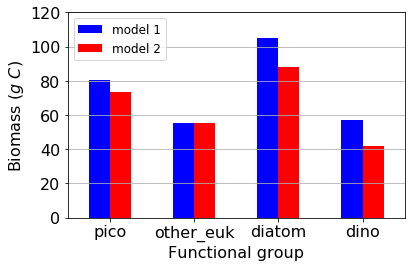

In [34]:
mpl.rc('font', **{'size' : 16})

ax=df.plot.bar(color=['blue','red'])
ax.set_xlabel('Functional group')
plt.setp(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Biomass ($g\ C$)')
ax.set_ylim(0,120)
ax.legend(loc='upper left', fontsize=12)
ax.grid(axis='y')
plt.tight_layout()

plt.savefig('car.0000000000.t001.lastyear.bar_grp_perc.png')

# Model 1 daily primary productivity

in $mg\ C\ m^{-2}\ d^{-1}$

In [35]:
ratesfile=os.path.join(indir_model1,'rates.0000000000.t001.nc')

# mmol C m^-3 s^-1
array2d_idepth_iT_PPfullmmolConm3s\
=netcdf_tools.read_netcdf(ratesfile, 'PP').squeeze().transpose()
molarmassC=12.0107 # g C (mol C)^-1
stod=86400 # 3600*24 s per d
array2d_idepth_iT_PPfull=array2d_idepth_iT_PPfullmmolConm3s*molarmassC*stod # mg C m^-3 d^-1
array1d_iT_dppfull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_PPfull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)
array1d_iT_dppmodel1=array1d_iT_dppfull[array1d_iT1y_iT_model1]

# Model 2 daily primary productivity

in $mg\ C\ m^{-2}\ d^{-1}$

In [36]:
ratesfile=os.path.join(indir_model2,'rates.0000000000.t001.nc')

# mmol C m^-3 s^-1
array2d_idepth_iT_PPfullmmolConm3s\
=netcdf_tools.read_netcdf(ratesfile, 'PP').squeeze().transpose()
molarmassC=12.0107 # g C (mol C)^-1
stod=86400 # 3600*24 s per d
array2d_idepth_iT_PPfull=array2d_idepth_iT_PPfullmmolConm3s*molarmassC*stod # mg C m^-3 d^-1
array1d_iT_dppfull\
=vstats.vintegrate(
    array2d_idepth_iT_tracer=array2d_idepth_iT_PPfull,
    array1d_idepth_delR=drF,
    idepth_start=0,
    idepth_end=RF_above81.size-1)
array1d_iT_dppmodel2=array1d_iT_dppfull[array1d_iT1y_iT_model2]

# Figure with many plots for one year

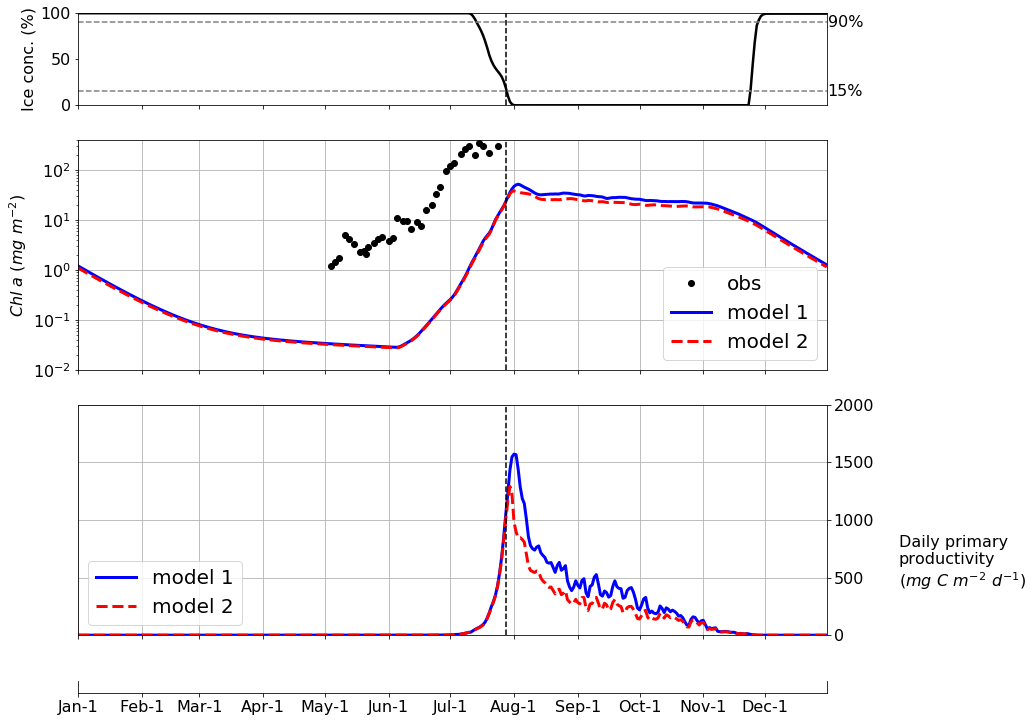

In [37]:
mpl.rc('font', **{'size' : 16})

locs=np.array([1, 32, 60, 91, 121, 152,
              182, 213, 244, 274, 305, 335])
labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
        'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

fig,axs=plt.subplots(4,1,sharex=False,figsize=(16, 16))

# --- ICE CONCENTRATIONS
ax=axs[0]
ax.plot(first_year+1,ice*100,'k-',lw=2.5)
ax.set_xlim(first_year[0]+1,first_year[-1]+1)
xlims=ax.get_xlim()
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_ylabel('Ice conc. (%)')
ax.set_ylim(0,100)
ax.plot(xlims,[15,15],'k--',color='gray')
ax.plot(xlims,[90,90],'k--',color='gray')
ax.text(xlims[1]+.5,15,'15%',verticalalignment='center')
ax.text(xlims[1]+.5,90,'90%',verticalalignment='center')

# adding the vertical line at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')

# --- PANEL B: CHLOROPHYLL A
ax=axs[1]
ax.plot(first_year+1,
        array1d_iT_obschl,
        'o',
        color='black',
        label='obs'
       )
ax.set_yscale('log')
ax.plot(first_year+1,
        array1d_iT_phytochlmodel1,
        '-',
        color='blue',
        lw=3,
        label='model 1'
       )
ax.plot(first_year+1,
        array1d_iT_phytochlmodel2,
        '--',
        color='red',
        lw=3,
        label='model 2'
       )
ax.set_xticks(locs)
ax.set_xticklabels([])
ax.set_xlim(xlims)
ax.set_ylim(1E-2,400)
ax.set_ylabel('$Chl\ a\ (mg\ m^{-2})$')
ax.legend(loc='lower right', fontsize=20)
ax.grid()

# adding the vertical line at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')

# --- DAILY PRIMARY PRODUCTIVITY
ax=axs[2]
ax.plot(first_year+1,
        array1d_iT_dppmodel1,
        '-',
        color='blue',
        lw=3,
        label='model 1')
ax.plot(first_year+1,
        array1d_iT_dppmodel2,
        '--',
        color='red',
        lw=3,
        label='model 2')
ax.set_xticklabels([])
ax.set_xticks(locs)
ax.set_xlim(xlims)
ax.yaxis.tick_right()
ax.set_yticks(range(0,2500,500))
ax.set_ylim(0,2000)
ax.grid()
ax.legend(loc='lower left', fontsize=20)
ax.text(400,625,'Daily primary\nproductivity\n($mg\ C\ m^{-2}\ d^{-1}$)',
        horizontalalignment = 'left',
        verticalalignment = 'center')

# adding the vertical line at 15% of ice
ax.axvline(iT15_start,color='k',linestyle='--')

# --- ADDITIONAL X-AXIS
ax=axs[3]
ax.set_xlim(xlims)
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)

# --- POSITION
axs[0].set_position( [0.12,0.88  ,0.65,.08])
axs[1].set_position( [0.12,0.65  ,0.65,.20])
axs[2].set_position( [0.12,0.42  ,0.65,.20])
axs[3].set_position( [0.12,0.37  ,0.65,.01])

# --- SAVE
plt.savefig('one.year.ac2020.png')

# Configure plots

In [38]:
# adapted from
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
# answer of Pedro M Duarte
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 56

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the x tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the y tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Plot

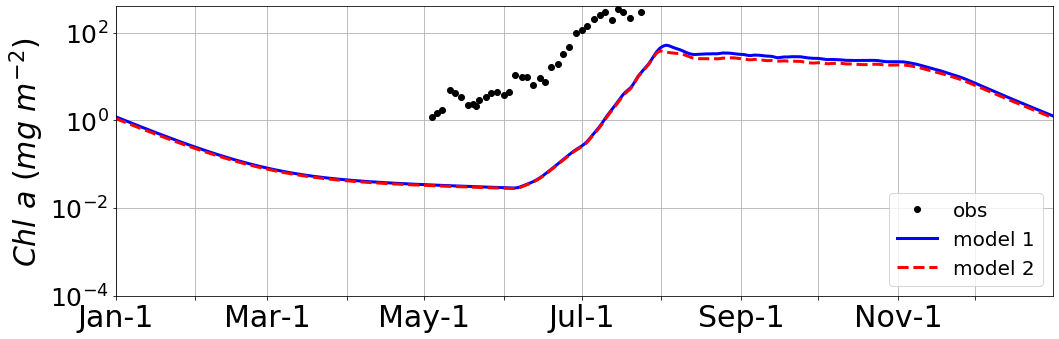

In [39]:
mpl.rc('font', **{'size' : 16})

locs=np.array([1, 32, 60, 91, 121, 152,
              182, 213, 244, 274, 305, 335])
labels=('Jan-1', '', 'Mar-1', '', 'May-1', '',
        'Jul-1', '', 'Sep-1', '', 'Nov-1', '')

plt.figure(figsize=(15,5))
ax = plt.gca()
ax.plot(first_year+1,
        array1d_iT_obschl,
        'o',
        color='black',
        label='obs'
       )
ax.set_yscale('log')
ax.plot(first_year+1,
        array1d_iT_phytochlmodel1,
        '-',
        color='blue',
        lw=3,
        label='model 1'
       )
ax.plot(first_year+1,
        array1d_iT_phytochlmodel2,
        '--',
        color='red',
        lw=3,
        label='model 2'
       )
ax.set_xlim(first_year[0]+1,first_year[-1]+1)
ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.set_xlim(xlims)
ax.set_ylim(1E-4,400)
ax.set_ylabel('$Chl\ a\ (mg\ m^{-2})$')
ax.legend(loc='lower right', fontsize=20)
ax.grid()
plt.tight_layout()
plt.savefig('GEic2016.one.year.logchl.comp.png')